In [1]:
!nvidia-smi

Fri Aug  4 17:40:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 5000     Off  | 00000000:1B:00.0 Off |                  Off |
| 33%   28C    P8    13W / 230W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install supervision
!pip install git+https://github.com/Deci-AI/super-gradients.git@master --upgrade &> /dev/null

In [3]:
import os
HOME = os.getcwd()
print(HOME)

/home


## Download Dataset

In [4]:
%cd {HOME}

DATASET_DIR = f'{HOME}/dataset'

!curl -L "https://storage.kuckuck.cam/datasets/v1/train.zip" > train.zip; unzip -q train.zip -d "{DATASET_DIR}"; rm train.zip
!curl -L "https://storage.kuckuck.cam/datasets/v1/val.zip" > val.zip; unzip -q val.zip -d "{DATASET_DIR}"; rm val.zip
!curl -L "https://storage.kuckuck.cam/datasets/v1/test.zip" > test.zip; unzip -q test.zip -d "{DATASET_DIR}"; rm test.zip

CHECKPOINT_DIR = f'{HOME}/checkpoints'
CLASSESFILE = f"{DATASET_DIR}/test/classes.txt"
PROJECTNAME = "project"
MODEL_ARCH = 'yolo_nas_l'
BATCH_SIZE = 8
MAX_EPOCHS = 100
EXPERIMENT_NAME = PROJECTNAME.lower().replace(" ", "_")
CLASSES = open(CLASSESFILE, "r").read().splitlines()
print("classes:", CLASSES)

/home
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1845M  100 1845M    0     0  19.2M      0  0:01:36  0:01:36 --:--:-- 20.3M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  279M  100  279M    0     0  17.3M      0  0:00:16  0:00:16 --:--:-- 21.0M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  516M  100  516M    0     0  18.4M      0  0:00:28  0:00:28 --:--:-- 21.1M0:12  0:00:19 21.1M14  0:00:16 20.8M
classes: ['bike', 'bus', 'car', 'motorbike', 'person', 'pickup', 'truck', 'van', 'awning-tricycle', 'motor', 'tricycle']


In [5]:
from super_gradients.training import Trainer

trainer = Trainer(experiment_name=EXPERIMENT_NAME, ckpt_root_dir=CHECKPOINT_DIR)

dataset_params = {
    'data_dir': DATASET_DIR,
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'val/images',
    'val_labels_dir':'val/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': CLASSES
}

[2023-08-04 17:44:08] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /home/sg_logs/console.log


[2023-08-04 17:44:11] INFO - font_manager.py - generated new fontManager
/opt/conda/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2023-08-04 17:44:12] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-08-04 17:44:12] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-08-04 17:44:12] WARNING - export.py - Failed to import pytorch_quantization
[2023-08-04 17:44:12] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2023-08-04 17:44:12] INFO - env_sanity_check.py - Library check is not supported when super_gradients installed through "git+https://github.com/..." command


In [6]:
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, coco_detection_yolo_format_val)

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 2
    }
)

[2023-08-04 17:44:12] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 7450/7450 [00:02<00:00, 3618.18it/s]
[2023-08-04 17:44:15] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 1090/1090 [00:00<00:00, 3609.89it/s]
[2023-08-04 17:44:15] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations:  74%|███████▍  | 1513/2042 [00:00<00:00, 3510.06it/s]

## Inspect

Indexing dataset annotations: 100%|██████████| 2042/2042 [00:00<00:00, 3553.57it/s]


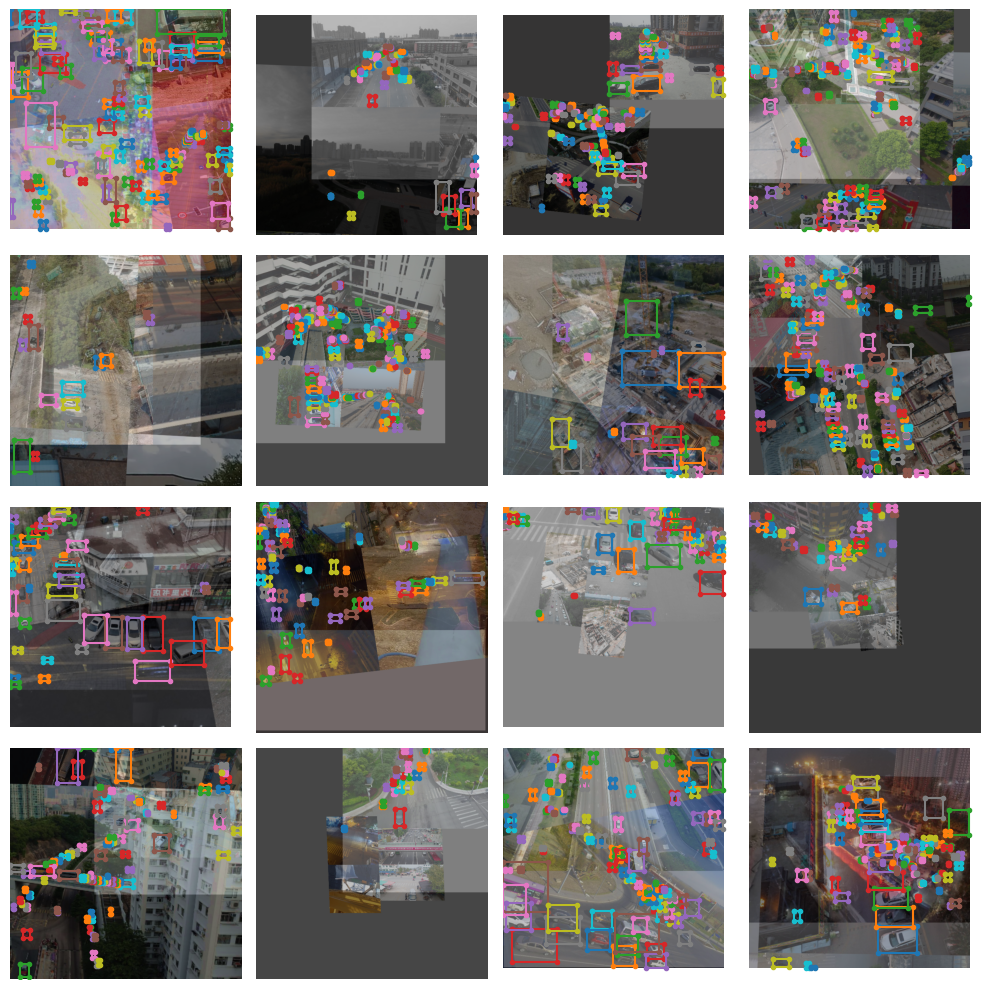

In [7]:
train_data.dataset.transforms
train_data.dataset.plot()

## Train

In [8]:
from super_gradients.training import models

model = models.get(
    MODEL_ARCH,
    num_classes=len(dataset_params['classes']),
    pretrained_weights="coco"
)

[2023-08-04 17:44:22] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_l_coco.pth" to /home/.cache/torch/hub/checkpoints/yolo_nas_l_coco.pth
100%|██████████| 256M/256M [00:02<00:00, 108MB/s]  
[2023-08-04 17:44:25] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_l


[Default train params](https://github.com/Deci-AI/super-gradients/blob/master/src/super_gradients/recipes/training_hyperparams/default_train_params.yaml)

In [9]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    'silent_mode': False,
    "resume": False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": MAX_EPOCHS,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [10]:
%load_ext tensorboard
%tensorboard --logdir {CHECKPOINT_DIR}/{EXPERIMENT_NAME}

In [ ]:
trainer.train(
    model=model,
    training_params=train_params,
    train_loader=train_data,
    valid_loader=val_data
)

The console stream is now moved to /home/checkpoints/project/console_Aug04_17_44_28.txt


[2023-08-04 17:44:31] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
[2023-08-04 17:44:34] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 7450       (len(train_set))
    - Batch size per GPU:           8          (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             8          (num_gpus * batch_size)
    - Effective Batch size:         8          (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         931        (len(train_loader))
    - Gradient updates per epoch:   931        (len(train_loader) / batch_accumulate)

[2023-08-04 17:44:34] INFO - sg_trainer.py - Started training for 100 epochs (0/99)

Train epoch 0:   3%|▎         | 25/931 [00:18<10:42,  1.41it/s, PPYoloELoss/loss=3.76, PPYoloELoss/loss_cl